# Import Modules

In [1]:
import os
import pandas as pd
import numpy.random as rnd
import warnings
import json
import sqlalchemy as sql
import datetime
import yfinance as yf
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
#from MCForecastTools import MCSimulation



%matplotlib inline

#warnings.filterwarnings("ignore")
#pd.options.display.float_format = '{:.4%}'.format

# Data Input for Universe (Multiple Asset Classes)

In [2]:
# Date range
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

# Tickers of assets
assets = ["MSFT", "TSLA", "META", "UNH", "JNJ", "JPM", "V", "LLY", "AVGO", "PG", "MA", "HD", "MRK", "NVDA", "AMZN", "BRK-B",
         "GOOG", "XOM", "CVX", "PEP", "COST", "KO", "ABBV", "ADBE", "WMT", "MCD", "CSCO", "CRM"]
assets.sort()

# Downloading data
og_data = yf.download(assets, start = start, end = end)
data = og_data.loc[:,('Adj Close', slice(None))]
data.columns = assets

Y = data[assets].pct_change().dropna()

display(start)
display(end)
display(Y)

[*********************100%***********************]  28 of 28 completed


'2018-07-08'

'2023-07-07'

,ABBV,ADBE,AMZN,AVGO,BRK-B,COST,CRM,CSCO,CVX,GOOG,...,MRK,MSFT,NVDA,PEP,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-10,0.018549,-0.004564,0.002329,0.012650,0.001371,0.003603,0.004867,0.004453,0.012699,-0.001049,...,0.004515,0.002651,0.016048,0.047606,0.025173,0.012433,0.007372,0.008633,0.014896,0.009168
2018-07-11,-0.039255,-0.002051,0.006844,-0.028416,0.000053,-0.003542,0.019656,-0.006766,-0.031899,0.000919,...,-0.006421,-0.001371,-0.022586,-0.003100,-0.008269,-0.010885,-0.003718,0.010681,-0.007797,-0.012790
2018-07-12,0.017127,0.027205,0.023715,-0.137447,0.000263,0.014553,0.020034,0.023726,0.005991,0.025635,...,0.012278,0.021671,0.014948,-0.008975,-0.003411,-0.007054,0.005735,0.012668,-0.000115,0.001211
2018-07-13,0.010668,0.014596,0.009134,-0.035813,0.005264,0.011774,-0.003712,-0.041303,-0.001770,0.004512,...,0.003671,0.011901,-0.007602,0.010401,0.005324,0.006820,0.010350,-0.003431,0.013638,0.007498
2018-07-16,-0.003932,-0.015120,0.005218,0.003902,0.005446,-0.007804,-0.004403,0.017233,-0.008546,-0.004172,...,-0.004770,-0.004932,-0.004492,0.002396,0.002774,-0.027503,-0.006649,-0.006886,-0.000684,-0.009843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29,0.005434,0.002778,-0.008834,0.017254,0.008260,-0.002083,-0.008201,0.006684,0.008521,-0.008837,...,0.009783,-0.002382,-0.007175,0.000980,-0.004067,0.004917,0.004194,0.027900,-0.006760,0.012334
2023-06-30,0.011259,0.010790,0.019234,0.005634,0.012140,0.012583,0.003944,0.010350,0.007104,0.007999,...,0.016294,0.016386,0.036255,0.007287,0.015799,0.016582,0.008815,0.013486,0.018797,0.005155
2023-07-03,0.002078,-0.007730,-0.001074,0.010387,0.002933,0.004941,0.001846,0.001546,-0.000890,-0.003389,...,-0.009186,-0.007488,0.002624,0.002052,0.005009,0.068954,-0.005742,0.002063,0.006489,0.001958


In [43]:
#Set the time period and trading days
rolling_window = 30
trading_days = 252

## Set up data for k-means model

In [41]:
# Calculate annual returns from daily returns
group_level = Y.index.year
annual_returns = Y.groupby(by=group_level).mean()
annual_returns

# Annual standard deviation
annual_stdev = annual_returns.std()*np.sqrt(trading_days)
annual_stdev.head()


ABBV     0.014126
ADBE     0.027606
AMZN     0.034033
AVGO     0.020951
BRK-B    0.005040
dtype: float64

In [44]:
# Calculate rolling 30 day returns from daily returns
thirty_day_rolling = Y.rolling(window = rolling_window).mean() 
thirty_day_rolling

# 30 day rolling standard deviation
thirty_day_stdev = thirty_day_rolling.std()*np.sqrt(rolling_window)
thirty_day_stdev.head()

ABBV     0.015852
ADBE     0.020932
AMZN     0.020776
AVGO     0.019318
BRK-B    0.012285
dtype: float64

In [46]:
# annual sharpe ratio
sharpe_ratio = (annual_returns /annual_stdev).median()
sharpe_ratio.head()

ABBV     0.041351
ADBE     0.041300
AMZN     0.016672
AVGO     0.074589
BRK-B    0.116159
dtype: float64

In [53]:
# combine all of the measures of variablity into one dataframe
asset_quant_data = pd.concat([annual_stdev,thirty_day_stdev,sharpe_ratio], axis =1)
asset_quant_data.columns = ('annual_stdev','thirty_day_stdev','sharpe_ratio')
asset_quant_data

,annual_stdev,thirty_day_stdev,sharpe_ratio
ABBV,0.014126,0.015852,0.041351
ADBE,0.027606,0.020932,0.041300
AMZN,0.034033,0.020776,0.016672
AVGO,0.020951,0.019318,0.074589
BRK-B,0.005040,0.012285,0.116159
COST,0.015724,0.014007,0.085212
CRM,0.031307,0.021290,0.023923
CSCO,0.012604,0.015912,0.038389
CVX,0.020940,0.020661,0.004555
GOOG,0.026469,0.016597,0.047015


## k-means modeling to cluster assets

In [54]:
# using a standard scaler to scale the variability metrics to avoid bias in the model

scaled_data = StandardScaler()

asset_data_scaled = scaled_data.fit_transform(asset_quant_data[['annual_stdev','thirty_day_stdev','sharpe_ratio']])



In [55]:
# Create a DataFrame with the scaled data
asset_data_scaled = pd.DataFrame(
    asset_data_scaled,
    columns=asset_quant_data.columns
)

# Copy the asset names from the original data
asset_data_scaled["Asset_Name"] = asset_quant_data.index

# Set the asset_name column as index
asset_data_scaled = asset_data_scaled.set_index("Asset_Name")

# Display sample data
asset_data_scaled.head()

,annual_stdev,thirty_day_stdev,sharpe_ratio
Asset_Name,,,
ABBV,-0.395312,-0.226767,-0.458733
ADBE,0.313964,0.436812,-0.459932
AMZN,0.652089,0.416425,-1.045704
AVGO,-0.036214,0.225926,0.331838
BRK-B,-0.873333,-0.692682,1.320556


In [56]:
# Create a list with the number of k-values to try
# Use a range from 1 to 10
k = list(range(1,10))

In [57]:
# Create an empy list to store the inertia values
inertia = []

In [58]:
for i in k:
    k_model = KMeans(n_clusters = i, random_state = 1)
    k_model.fit(asset_data_scaled)
    inertia.append(k_model.inertia_)

In [59]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k":k, "inertia":inertia}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

#check dataframe
elbow_df.head()

,k,inertia
0,1,84.000000
1,2,40.643559
2,3,19.401251
3,4,11.376224
4,5,8.277251


In [60]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.hvplot.line(x = "k", y = "inertia", title = "Elbow Curve", xticks = k)

:Curve   [k]   (inertia)

In [61]:
# Initialize the K-Means model using the best value for k
model = KMeans (n_clusters = 4, random_state = 1)

In [62]:
# Fit the K-Means model using the scaled data
model.fit(asset_data_scaled)

KMeans(n_clusters=4, random_state=1)

In [63]:
# Predict the clusters to group the assets using the scaled data
k = model.predict(asset_data_scaled)

# View the resulting array of cluster values.
k

array([1, 2, 2, 1, 3, 1, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 3, 0, 1, 1, 0, 3,
       1, 0, 1, 1, 3, 2])

In [64]:
# Create a copy of the DataFrame
asset_data_scaled_predict = asset_data_scaled.copy()

In [65]:
# Add a new column to the DataFrame with the predicted clusters
asset_data_scaled_predict["clusters"] = k

# Display sample data
asset_data_scaled_predict.head()

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters
Asset_Name,,,,
ABBV,-0.395312,-0.226767,-0.458733,1
ADBE,0.313964,0.436812,-0.459932,2
AMZN,0.652089,0.416425,-1.045704,2
AVGO,-0.036214,0.225926,0.331838,1
BRK-B,-0.873333,-0.692682,1.320556,3


## Charts and summary of k-means

In [66]:
# Create a scatter plot using hvPlot by setting 
# `x="Sharpe Ratio"` and `y="Annual Average Returns"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the assets represented by each data point.
asset_data_scaled_predict.hvplot.scatter(
    x="annual_stdev", 
    y="sharpe_ratio",
    by = "clusters",
    hover_cols = "all").opts(yformatter="%.0f")


:NdOverlay   [clusters]
   :Scatter   [annual_stdev]   (sharpe_ratio,Asset_Name,thirty_day_stdev,clusters)

In [71]:
#list the clusters
cluster1 = portfolio_model.where(asset_data_scaled_predict["clusters"]==0).dropna()
cluster1

NameError: name 'portfolio_model' is not defined

In [26]:
cluster2 = portfolio_model.where(portfolio_model["clusters"]==1).dropna()
cluster2

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,Annual Average Returns
ADBE,0.622882,0.622882,-0.546337,1.0,0.207727
AMZN,0.458081,0.458081,-1.096318,1.0,0.150822
CRM,0.777728,0.777728,-1.150611,1.0,0.159146
CSCO,-0.291906,-0.291906,-1.238829,1.0,0.109456
CVX,0.379729,0.379729,-1.001641,1.0,0.155566
GOOG,0.015613,0.015613,-0.186549,1.0,0.201446
HD,-0.285275,-0.285275,-0.503439,1.0,0.160327
JPM,0.047671,0.047671,-0.885457,1.0,0.149756
MA,0.115559,0.115559,-0.337735,1.0,0.195984
META,1.281927,1.281927,-1.229445,1.0,0.171291


In [27]:
cluster3 = portfolio_model.where(portfolio_model["clusters"]==2).dropna()
cluster3

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,Annual Average Returns
NVDA,2.148116,2.148116,1.332817,2.0,0.532515
TSLA,3.417670,3.417670,1.866641,2.0,0.745430


In [28]:
cluster4 = portfolio_model.where(portfolio_model["clusters"]==3).dropna()
cluster4

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,Annual Average Returns
ABBV,-0.513832,-0.513832,-0.475000,3.0,0.149217
BRK-B,-0.899944,-0.899944,-0.120469,3.0,0.146258
JNJ,-1.119291,-1.119291,-0.772850,3.0,0.100123
KO,-1.018870,-1.018870,-0.562655,3.0,0.115867
MCD,-0.825251,-0.825251,0.293645,3.0,0.174251
MRK,-0.851236,-0.851236,0.600010,3.0,0.189162
PEP,-0.965536,-0.965536,0.201084,3.0,0.158771
PG,-0.989933,-0.989933,0.671424,3.0,0.181312
WMT,-0.904086,-0.904086,0.304678,3.0,0.168868


## Leveraging Machine Learning to Create trades of Equity within cluster

In [29]:
# Create a list of assets from a cluster.
cluster_list = []
cluster_list = cluster2.index

list(cluster_list)


['ADBE',
 'AMZN',
 'CRM',
 'CSCO',
 'CVX',
 'GOOG',
 'HD',
 'JPM',
 'MA',
 'META',
 'UNH',
 'V',
 'XOM']

In [30]:
#Slice input dataframe Y with cluster with timestamp data as index
signals_df = pd.DataFrame(Y, columns = list(cluster_list)).reset_index()

#set data frame date colume to date time index
signals_df['Date']=pd.to_datetime(signals_df['Date'],
                                         infer_datetime_format=True,
                                 )

signals_df = signals_df.set_index('Date')

#show data frame 
signals_df.head()

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM
Date,,,,,,,,,,,,,
2018-07-09,0.006366,0.016596,0.002546,-0.000937,0.014903,0.012174,0.008227,0.030944,0.007067,0.007430,0.011605,0.010665,0.006923
2018-07-10,-0.004564,0.002329,0.004867,0.004453,0.012699,-0.001049,0.007803,-0.006152,0.002936,-0.005861,0.007372,0.008633,0.009168
2018-07-11,-0.002051,0.006844,0.019656,-0.006766,-0.031899,0.000919,-0.003340,-0.002157,0.011513,-0.004913,-0.003718,0.010681,-0.012790
2018-07-12,0.027205,0.023715,0.020034,0.023726,0.005991,0.025635,0.005078,0.004324,0.019329,0.021625,0.005735,0.012668,0.001211
2018-07-13,0.014596,0.009134,-0.003712,-0.041304,-0.001771,0.004512,0.003738,-0.004586,-0.009000,0.001933,0.010350,-0.003431,0.007498


In [31]:
# Set the short window and long window
short_window = 10
long_window = 90

# Generate the fast and slow simple moving averages (10 and 90 days, respectively for one Asset)
signals_df['SMA_Fast'] = signals_df[cluster_list[0]].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df[cluster_list[0]].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow
Date,,,,,,,,,,,,,,,
2018-11-12,-0.033369,-0.044136,-0.046889,-0.031628,-0.017739,-0.025812,-0.035271,-0.021026,-0.031514,-0.023524,-0.015079,-0.029250,-0.012860,-0.000991,-0.000261
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011601,0.000000,-0.022924,0.000442,-0.000234
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003207,0.007345,0.005028,-0.020623,-0.002977,0.014491,-0.015824,-0.001646,-0.007820,-0.004115,-0.000347
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018673,0.010337,-0.001909,-0.000101
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000726,-0.008320,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453


,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow
Date,,,,,,,,,,,,,,,
2023-06-27,0.020354,0.014529,0.007041,0.012946,-0.003117,-0.000672,0.019000,0.000072,0.011579,0.030811,0.007306,0.004596,0.002493,0.003144,0.003211
2023-06-28,-0.013980,-0.001084,0.016042,0.000197,0.009054,0.017393,-0.023044,-0.004382,-0.004086,-0.006131,-0.016806,0.002727,0.008130,0.000827,0.003375
2023-06-29,0.002778,-0.008834,-0.008201,0.006684,0.008521,-0.008837,0.004274,0.034923,0.019567,-0.013180,0.004194,0.027900,0.012334,0.000992,0.003658
2023-06-30,0.010790,0.019234,0.003944,0.010350,0.007104,0.007999,0.009161,0.014014,0.014523,0.019359,0.008815,0.013486,0.005155,-0.000302,0.004094
2023-07-03,-0.007730,-0.001074,0.001846,0.001546,-0.000890,-0.003389,-0.001996,0.008045,0.001678,-0.003345,-0.005742,0.002063,0.001958,-0.001945,0.003944


In [32]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df[cluster_list[0]] >= 0), 'Signal'] = 1

# When Actual Returns are less than -1, generate signal to sell the stock short
signals_df.loc[(signals_df[cluster_list[0]] < 0), 'Signal'] = 0

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal
Date,,,,,,,,,,,,,,,,
2018-11-12,-0.033369,-0.044136,-0.046889,-0.031628,-0.017739,-0.025812,-0.035271,-0.021026,-0.031514,-0.023524,-0.015079,-0.029250,-0.012860,-0.000991,-0.000261,0.0
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011601,0.000000,-0.022924,0.000442,-0.000234,1.0
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003207,0.007345,0.005028,-0.020623,-0.002977,0.014491,-0.015824,-0.001646,-0.007820,-0.004115,-0.000347,0.0
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018673,0.010337,-0.001909,-0.000101,1.0
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000726,-0.008320,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0


,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal
Date,,,,,,,,,,,,,,,,
2023-06-27,0.020354,0.014529,0.007041,0.012946,-0.003117,-0.000672,0.019000,0.000072,0.011579,0.030811,0.007306,0.004596,0.002493,0.003144,0.003211,1.0
2023-06-28,-0.013980,-0.001084,0.016042,0.000197,0.009054,0.017393,-0.023044,-0.004382,-0.004086,-0.006131,-0.016806,0.002727,0.008130,0.000827,0.003375,0.0
2023-06-29,0.002778,-0.008834,-0.008201,0.006684,0.008521,-0.008837,0.004274,0.034923,0.019567,-0.013180,0.004194,0.027900,0.012334,0.000992,0.003658,1.0
2023-06-30,0.010790,0.019234,0.003944,0.010350,0.007104,0.007999,0.009161,0.014014,0.014523,0.019359,0.008815,0.013486,0.005155,-0.000302,0.004094,1.0
2023-07-03,-0.007730,-0.001074,0.001846,0.001546,-0.000890,-0.003389,-0.001996,0.008045,0.001678,-0.003345,-0.005742,0.002063,0.001958,-0.001945,0.003944,0.0


In [33]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df[cluster_list[0]] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,,,,,,,,,,,,
2018-11-12,-0.033369,-0.044136,-0.046889,-0.031628,-0.017739,-0.025812,-0.035271,-0.021026,-0.031514,-0.023524,-0.015079,-0.029250,-0.012860,-0.000991,-0.000261,0.0,NaN
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011601,0.000000,-0.022924,0.000442,-0.000234,1.0,0.000000
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003207,0.007345,0.005028,-0.020623,-0.002977,0.014491,-0.015824,-0.001646,-0.007820,-0.004115,-0.000347,0.0,-0.014744
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018673,0.010337,-0.001909,-0.000101,1.0,0.000000
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000726,-0.008320,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0,-0.004418


,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,,,,,,,,,,,,
2023-06-27,0.020354,0.014529,0.007041,0.012946,-0.003117,-0.000672,0.019000,0.000072,0.011579,0.030811,0.007306,0.004596,0.002493,0.003144,0.003211,1.0,0.00000
2023-06-28,-0.013980,-0.001084,0.016042,0.000197,0.009054,0.017393,-0.023044,-0.004382,-0.004086,-0.006131,-0.016806,0.002727,0.008130,0.000827,0.003375,0.0,-0.01398
2023-06-29,0.002778,-0.008834,-0.008201,0.006684,0.008521,-0.008837,0.004274,0.034923,0.019567,-0.013180,0.004194,0.027900,0.012334,0.000992,0.003658,1.0,0.00000
2023-06-30,0.010790,0.019234,0.003944,0.010350,0.007104,0.007999,0.009161,0.014014,0.014523,0.019359,0.008815,0.013486,0.005155,-0.000302,0.004094,1.0,0.01079
2023-07-03,-0.007730,-0.001074,0.001846,0.001546,-0.000890,-0.003389,-0.001996,0.008045,0.001678,-0.003345,-0.005742,0.002063,0.001958,-0.001945,0.003944,0.0,-0.00773


<Axes: xlabel='Date'>

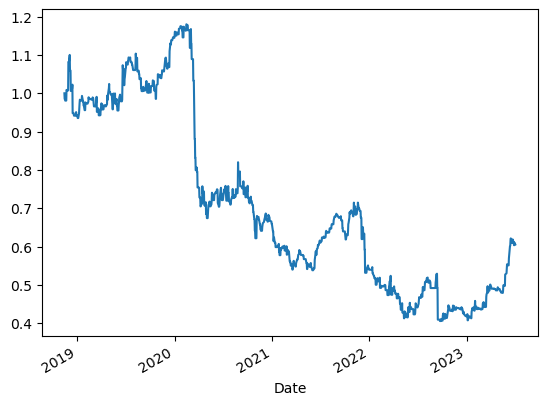

In [34]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [35]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2018-11-13,-0.000991,-0.000261
2018-11-14,0.000442,-0.000234
2018-11-15,-0.004115,-0.000347
2018-11-16,-0.001909,-0.000101
2018-11-19,-0.000051,-0.000453


In [36]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

1.0    629
0.0    537
Name: Signal, dtype: int64

In [37]:
# slice the dataframe to exclude any data before the first half of 2020
X = X['2020-07-01' : end]

In [38]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)
type(training_begin)

2020-07-01 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

In [39]:
# Select the ending period for the training data with an offset of 6 months
training_end = X.index.min()+ DateOffset(months=6)

# Display the training end date
print(training_end)

2021-01-01 00:00:00


In [40]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-01,0.005736,0.002600
2020-07-02,0.006328,0.003178
2020-07-06,0.005356,0.003556
2020-07-07,0.005737,0.003685
2020-07-08,0.002540,0.004042


In [41]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-01,0.005736,0.002600
2020-07-02,0.006328,0.003178
2020-07-06,0.005356,0.003556
2020-07-07,0.005737,0.003685
2020-07-08,0.002540,0.004042


In [42]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [43]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled,y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Backtesting data for the trading model

In [44]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Generate classification report
report = svm_testing_report

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       304
         1.0       0.52      1.00      0.68       324

    accuracy                           0.52       628
   macro avg       0.26      0.50      0.34       628
weighted avg       0.27      0.52      0.35       628



In [45]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df[cluster_list[0]]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2021-01-04,1.0,-0.029553,-0.029553
2021-01-05,1.0,0.000721,0.000721
2021-01-06,1.0,-0.039902,-0.039902
2021-01-07,1.0,0.024512,0.024512
2021-01-08,1.0,0.015406,0.015406


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-06-27,1.0,0.020354,0.020354
2023-06-28,1.0,-0.013980,-0.013980
2023-06-29,1.0,0.002778,0.002778
2023-06-30,1.0,0.010790,0.010790
2023-07-03,1.0,-0.007730,-0.007730


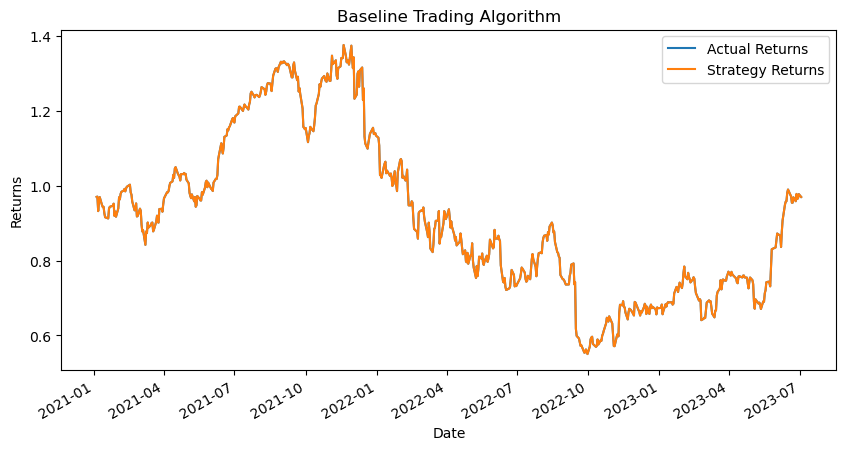

In [46]:
# Plot the actual returns versus the strategy returns
fig1 = (1+predictions_df[['Actual Returns','Strategy Returns']]).cumprod().plot(title = 'Baseline Trading Algorithm',
                                                                                          figsize = (10,5),
                                                                                                 ylabel = 'Returns'
                                                        
                                                                                         ).figure

# Files used to save charts commented out to not override current files
#fig1.savefig('images/baseline_3month_window_10_90days.png', bbox_inches ='tight')

## Adding trading costs to Backtesting Data

In [47]:
# Every time we change from long to short, or vice-versa, 2 trades occur
signals_df["Trades"] = np.abs(signals_df["Signal"].diff())

# Display sample data
signals_df.head()

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Trades
Date,,,,,,,,,,,,,,,,,,
2018-11-12,-0.033369,-0.044136,-0.046889,-0.031628,-0.017739,-0.025812,-0.035271,-0.021026,-0.031514,-0.023524,-0.015079,-0.029250,-0.012860,-0.000991,-0.000261,0.0,NaN,NaN
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011601,0.000000,-0.022924,0.000442,-0.000234,1.0,0.000000,1.0
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003207,0.007345,0.005028,-0.020623,-0.002977,0.014491,-0.015824,-0.001646,-0.007820,-0.004115,-0.000347,0.0,-0.014744,1.0
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018673,0.010337,-0.001909,-0.000101,1.0,0.000000,1.0
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000726,-0.008320,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0,-0.004418,1.0


In [48]:
# Calculate total daily trade costs
cost_per_trade = 0.005
daily_trade_costs = signals_df["Trades"] * cost_per_trade

# Display sample data
daily_trade_costs.head()

Date
2018-11-12      NaN
2018-11-13    0.005
2018-11-14    0.005
2018-11-15    0.005
2018-11-16    0.005
Name: Trades, dtype: float64

In [49]:
# Calculate strategy returns after costs
signals_df["Strategy Returns (After Costs)"] = signals_df["Strategy Returns"] - daily_trade_costs
signals_df.head()

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Trades,Strategy Returns (After Costs)
Date,,,,,,,,,,,,,,,,,,,
2018-11-12,-0.033369,-0.044136,-0.046889,-0.031628,-0.017739,-0.025812,-0.035271,-0.021026,-0.031514,-0.023524,-0.015079,-0.029250,-0.012860,-0.000991,-0.000261,0.0,NaN,NaN,NaN
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011601,0.000000,-0.022924,0.000442,-0.000234,1.0,0.000000,1.0,-0.005000
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003207,0.007345,0.005028,-0.020623,-0.002977,0.014491,-0.015824,-0.001646,-0.007820,-0.004115,-0.000347,0.0,-0.014744,1.0,-0.019744
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018673,0.010337,-0.001909,-0.000101,1.0,0.000000,1.0,-0.005000
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000726,-0.008320,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0,-0.004418,1.0,-0.009418


<Axes: xlabel='Date'>

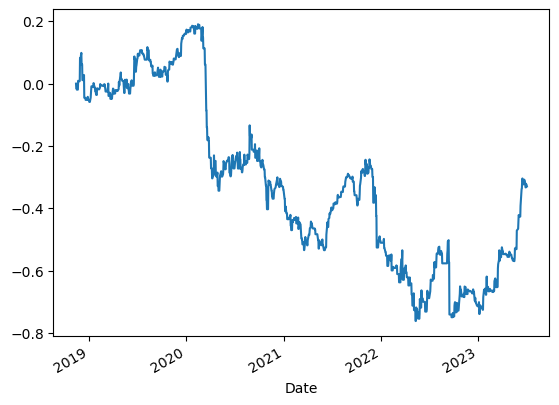

In [50]:
# Calculate the strategy's returns
strategy_returns = signals_df["Strategy Returns"].cumsum()

# Plot Strategy Returns to examine performance
strategy_returns.plot()

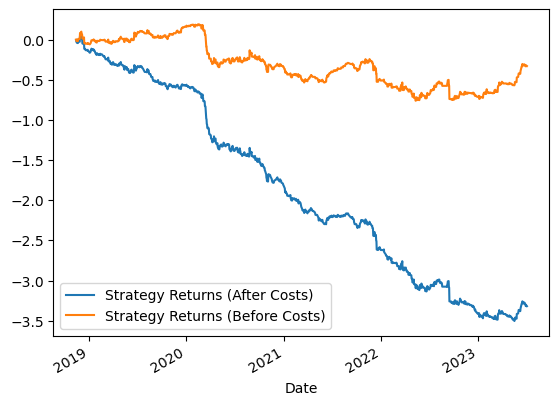

In [51]:
# Compute total strategy returns after costs
strategy_returns_after_costs = signals_df["Strategy Returns (After Costs)"].cumsum()

# Plot stategy returns before and after costs
strategy_returns_after_costs.plot(label="Strategy Returns (After Costs)")
strategy_returns.plot(label="Strategy Returns (Before Costs)")
plt.legend()

*Optimal Weighted Portfolio on Cluster 2*

In [80]:
assets_in_cluster = []
assets_in_cluster = cluster2.index.values.tolist()

assets_in_cluster



['ADBE',
 'AMZN',
 'CRM',
 'CSCO',
 'CVX',
 'GOOG',
 'HD',
 'JPM',
 'MA',
 'META',
 'UNH',
 'V',
 'XOM']

In [81]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

cluster_stock_data = yf.download(assets_in_cluster, start = start, end = end)
adj_close_prices = cluster_stock_data.loc[:,('Adj Close', slice(None))]
adj_close_prices.columns = assets_in_cluster

display(start)
display(end)
display(adj_close_prices)

[*********************100%***********************]  13 of 13 completed


'2018-07-06'

'2023-07-05'

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM
Date,,,,,,,,,,,,,
2018-07-06,248.190002,85.531502,141.399994,36.995480,99.701530,57.008499,172.284927,90.063927,194.397797,203.229996,232.875549,129.686310,63.553833
2018-07-09,249.770004,86.950996,141.759995,36.960831,101.187340,57.702499,173.702362,92.850838,195.771637,204.740005,235.578033,131.069305,63.993820
2018-07-10,248.630005,87.153503,142.449997,37.125408,102.472351,57.641998,175.057724,92.279610,196.346481,203.539993,237.314651,132.200882,64.580505
2018-07-11,248.119995,87.750000,145.250000,36.874210,99.203583,57.695000,174.473007,92.080521,198.606903,202.539993,236.432404,133.612946,63.754520
2018-07-12,254.869995,89.831001,148.160004,37.749073,99.797920,59.174000,175.358932,92.478683,202.445740,206.919998,237.788300,135.305496,63.831734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27,489.269989,129.179993,208.820007,50.860001,153.529999,119.010002,313.739990,139.199997,381.790009,287.049988,482.559998,227.339996,104.550003
2023-06-28,482.429993,129.039993,212.169998,50.869999,154.919998,121.080002,306.510010,138.589996,380.230011,285.290009,474.450012,227.960007,105.400002
2023-06-29,483.769989,127.900002,210.429993,51.209999,156.240005,120.010002,307.820007,143.429993,387.670013,281.529999,476.440002,234.320007,106.699997


In [82]:
mu = mean_historical_return(adj_close_prices)
S = CovarianceShrinkage(adj_close_prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('ADBE', 0.07555),
             ('AMZN', 0.0),
             ('CRM', 0.0),
             ('CSCO', 0.0),
             ('CVX', 0.0),
             ('GOOG', 0.23135),
             ('HD', 0.12289),
             ('JPM', 0.0),
             ('MA', 0.13924),
             ('META', 0.0),
             ('UNH', 0.26484),
             ('V', 0.07901),
             ('XOM', 0.08711)])

In [83]:
ef.portfolio_performance(verbose=True)

Expected annual return: 14.6%
Annual volatility: 24.3%
Sharpe Ratio: 0.52


(0.14609167865283604, 0.24269411353435635, 0.5195498020803303)

In [89]:
latest_prices = get_latest_prices(adj_close_prices)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000) #total_portfolio_value=100000 CHANGE THIS TO OUTPUT FROM LEX ANSWER
allocation, leftover = da.lp_portfolio()
allocation

{'ADBE': 16, 'GOOG': 192, 'HD': 40, 'MA': 35, 'UNH': 55, 'V': 33, 'XOM': 81}

In [97]:
allocation_weights = []
for key in allocation:
    allocation_weights.append(allocation[key])

total_shares = sum(allocation_weights)
total_shares

allocation_weights = [x / total_shares for x in allocation_weights]
allocation_weights  

allocated_tickers = list(allocation.keys())
allocated_tickers

['ADBE', 'GOOG', 'HD', 'MA', 'UNH', 'V', 'XOM']

In [100]:
dfs = []

for ticker in allocated_tickers:
    data = yf.download(ticker, start, interval='1d')
    open_df = pd.DataFrame(data['Open']).rename(columns={'Open': 'open'})
    adj_close_df = pd.DataFrame(data['Adj Close']).rename(columns={'Adj Close': 'close'})
    daily_return_df = pd.DataFrame(data['Adj Close'].pct_change()).rename(columns={'Adj Close': 'daily_return'})
    dfs.append(pd.concat([open_df, adj_close_df, daily_return_df], axis=1, keys=[ticker]*3))

allocated_data = pd.concat(dfs, axis=1).dropna()
allocated_data 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ADBE                                 GOOG              \
                  open       close daily_return        open       close   
Date                                                                      
2018-07-09  249.899994  249.770004     0.006366   57.424000   57.702499   
2018-07-10  250.470001  248.630005    -0.004564   57.848999   57.641998   
2018-07-11  246.649994  248.119995    -0.002051   57.229500   57.695000   
2018-07-12  249.940002  254.869995     0.027205   57.994499   59.174000   
2018-07-13  254.639999  258.589996     0.014596   59.250000   59.441002   
...                ...         ...          ...         ...         ...   
2023-06-28  482.000000  482.429993    -0.013980  117.959999  121.080002   
2023-06-29  484.470001  483.769989     0.002778  120.089996  120.010002   
2023-06-30  482.739990  488.989990     0.010790  121.099998  120.970001   
2023-07-03  486.390015  485.209991    -0.007730  120.320000  120.559998   
2023-07-05  480.989990  487.260010     0.004225  120.059998  122.629997   

                                 HD                                   MA  ...  \
           daily_return        open       close daily_return        open  ...   
Date                                                                      ...   
2018-07-09     0.012174  195.699997  173.702301     0.008227  200.800003  ...   
2018-07-10    -0.001049  196.559998  175.057755     0.007803  201.339996  ...   
2018-07-11     0.000919  197.220001  174.473068    -0.003340  200.470001  ...   
2018-07-12     0.025635  198.199997  175.358917     0.005077  205.000000  ...   
2018-07-13     0.004512  198.460007  176.014465     0.003738  207.100006  ...   
...                 ...         ...         ...          ...         ...  ...   
2023-06-28     0.017393  312.000000  306.510010    -0.023044  381.190002  ...   
2023-06-29    -0.008837  306.779999  307.820007     0.004274  380.850006  ...   
2023-06-30     0.007999  309.579987  310.640015     0.009161  388.100006  ...   
2023-07-03    -0.003389  309.779999  310.019989    -0.001996  391.339996  ...   
2023-07-05     0.017170  310.500000  310.799988     0.002516  388.809998  ...   

                                UNH                                    V  \
           daily_return        open       close daily_return        open   
Date                                                                       
2018-07-09     0.007067  252.130005  235.578049     0.011605  134.940002   
2018-07-10     0.002937  254.179993  237.314651     0.007372  135.570007   
2018-07-11     0.011512  255.139999  236.432419    -0.003718  136.630005   
2018-07-12     0.019329  256.179993  237.788284     0.005735  139.009995   
2018-07-13    -0.009000  256.390015  240.249313     0.010350  139.789993   
...                 ...         ...         ...          ...         ...   
2023-06-28    -0.004086  481.959991  474.450012    -0.016806  227.500000   
2023-06-29     0.019567  475.079987  476.440002     0.004194  228.789993   
2023-06-30     0.014523  478.000000  480.640015     0.008815  236.270004   
2023-07-03     0.001678  478.100006  477.880005    -0.005742  237.000000   
2023-07-05     0.001955  476.029999  471.220001    -0.013937  234.410004   

                                            XOM                           
                 close daily_return        open       close daily_return  
Date                                                                      
2018-07-09  131.069336     0.010664   82.809998   63.993832     0.006924  
2018-07-10  132.200912     0.008633   83.699997   64.580505     0.009168  
2018-07-11  133.612946     0.010681   83.029999   63.754539    -0.012790  
2018-07-12  135.305481     0.012667   83.010002   63.831718     0.001211  
2018-07-13  134.841263    -0.003431   82.680000   64.310318     0.007498  
...                ...          ...         ...         ...          ...  
2023-06-28  227.960007     0.002727  104.309998  105.400002     0.008130  
2023-06-29  234.3

In [98]:
allocated_closing_prices = adj_close_prices[allocated_tickers]
allocated_closing_prices

,ADBE,GOOG,HD,MA,UNH,V,XOM
Date,,,,,,,
2018-07-06,248.190002,57.008499,172.284927,194.397797,232.875549,129.686310,63.553833
2018-07-09,249.770004,57.702499,173.702362,195.771637,235.578033,131.069305,63.993820
2018-07-10,248.630005,57.641998,175.057724,196.346481,237.314651,132.200882,64.580505
2018-07-11,248.119995,57.695000,174.473007,198.606903,236.432404,133.612946,63.754520
2018-07-12,254.869995,59.174000,175.358932,202.445740,237.788300,135.305496,63.831734
...,...,...,...,...,...,...,...
2023-06-27,489.269989,119.010002,313.739990,381.790009,482.559998,227.339996,104.550003
2023-06-28,482.429993,121.080002,306.510010,380.230011,474.450012,227.960007,105.400002
2023-06-29,483.769989,120.010002,307.820007,387.670013,476.440002,234.320007,106.699997


In [102]:
investment_timeframe = 5
monte_carlo_simulation = MCSimulation(
    portfolio_data= allocated_data,
    weights=allocation_weights,
    num_simulation=500,
    num_trading_days=252*investment_timeframe,
)

monte_carlo_simulation.portfolio_data.head()

ADBE                                GOOG             \
                  open       close daily_return       open      close   
Date                                                                    
2018-07-09  249.899994  249.770004     0.006366  57.424000  57.702499   
2018-07-10  250.470001  248.630005    -0.004564  57.848999  57.641998   
2018-07-11  246.649994  248.119995    -0.002051  57.229500  57.695000   
2018-07-12  249.940002  254.869995     0.027205  57.994499  59.174000   
2018-07-13  254.639999  258.589996     0.014596  59.250000  59.441002   

                                 HD                                   MA  ...  \
           daily_return        open       close daily_return        open  ...   
Date                                                                      ...   
2018-07-09     0.012174  195.699997  173.702301     0.008227  200.800003  ...   
2018-07-10    -0.001049  196.559998  175.057755     0.007803  201.339996  ...   
2018-07-11     0.000919  197.220001  174.473068    -0.003340  200.470001  ...   
2018-07-12     0.025635  198.199997  175.358917     0.005077  205.000000  ...   
2018-07-13     0.004512  198.460007  176.014465     0.003738  207.100006  ...   

                                UNH                                    V  \
           daily_return        open       close daily_return        open   
Date                                                                       
2018-07-09     0.007067  252.130005  235.578049     0.011605  134.940002   
2018-07-10     0.002937  254.179993  237.314651     0.007372  135.570007   
2018-07-11     0.011512  255.139999  236.432419    -0.003718  136.630005   
2018-07-12     0.019329  256.179993  237.788284     0.005735  139.009995   
2018-07-13    -0.009000  256.390015  240.249313     0.010350  139.789993   

                                           XOM                          
                 close daily_return       open      close daily_return  
Date                                                                    
2018-07-09  131.069336     0.010664  82.809998  63.993832     0.006924  
2018-07-10  132.200912     0.008633  83.699997  64.580505     0.009168  
2018-07-11  133.612946     0.010681  83.029999  63.754539    -0.012790  
2018-07-12  135.305481     0.012667  83.010002  63.831718     0.001211  
2018-07-13  134.841263    -0.003431  82.680000  64.310318     0.007498  

[5 rows x 21 columns]

In [103]:
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.981951,0.998065,1.012454,0.999226,1.000919,0.991941,1.002079,0.995048,1.006228,0.982713,...,0.995857,1.003103,1.009571,0.995555,1.009977,1.009758,1.003229,1.009749,1.000042,1.008597
2,0.969586,1.002376,1.015219,0.994187,0.988323,0.980826,1.001900,0.979718,1.018227,0.981983,...,0.991547,0.998593,1.008175,0.996424,1.006807,1.030602,1.009319,1.004876,1.003755,0.994885
3,0.973001,0.992861,1.026415,0.990550,0.993450,0.982615,1.002459,0.973130,1.037038,0.990282,...,0.998792,0.999030,1.003545,0.995158,1.005757,1.053667,1.017892,1.002860,1.007536,0.989331
4,0.981448,1.002429,1.027301,0.987321,1.001200,0.985425,0.993336,0.969362,1.043655,0.995394,...,1.015663,0.993950,1.008835,1.017397,1.012023,1.054668,1.015001,0.998261,0.998371,0.997417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.465067,2.289120,3.445873,1.562120,3.822376,3.238466,1.272515,2.153641,1.983811,3.982272,...,2.076669,4.895526,1.643099,4.106004,3.903884,2.836386,2.007290,3.948027,2.039308,2.135489
1257,3.487753,2.300203,3.449296,1.589029,3.815817,3.221148,1.286939,2.180587,1.993901,3.992882,...,2.080969,4.819884,1.635572,4.101153,3.986010,2.889051,2.042529,4.011540,2.026438,2.125567
1258,3.499468,2.279992,3.502751,1.572292,3.800653,3.231035,1.287724,2.182625,2.018384,4.028528,...,2.072932,4.845189,1.634587,4.073548,4.003959,2.935772,2.067978,4.081057,2.026206,2.141887
1259,3.524572,2.303287,3.521012,1.587443,3.843767,3.207871,1.279701,2.178738,2.012632,4.069534,...,2.116082,4.833616,1.635433,4.002048,4.026714,2.890040,2.026314,4.114809,2.057961,2.142863


<Axes: title={'center': '500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

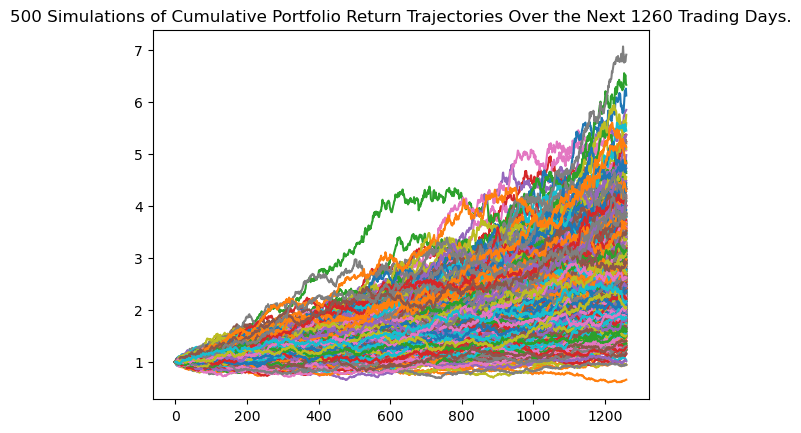

In [104]:
monte_carlo_simulation.plot_simulation()

<Axes: title={'center': 'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

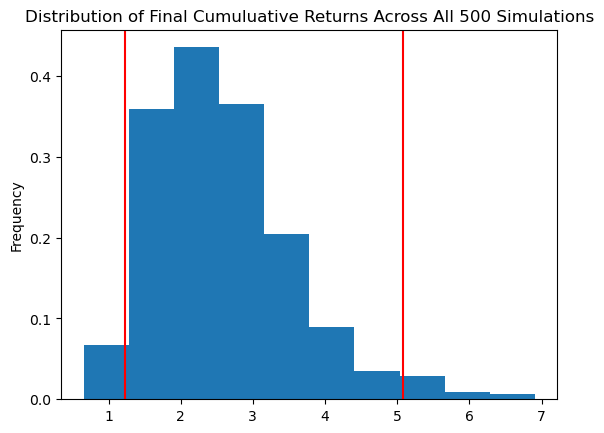

In [105]:
monte_carlo_simulation.plot_distribution()

In [108]:
monte_carlo_simulation_statistics = monte_carlo_simulation.summarize_cumulative_return()
monte_carlo_simulation_statistics

count           500.000000
mean              2.588317
std               0.969047
min               0.659371
25%               1.884403
50%               2.427164
75%               3.121154
max               6.907341
95% CI Lower      1.233045
95% CI Upper      5.085504
Name: 1260, dtype: float64

In [109]:
ci_lower_ten_cumulative_return = monte_carlo_simulation_statistics[8]
ci_upper_ten_cumulative_return = monte_carlo_simulation_statistics[9]

In [110]:
print(f"There is a 95% chance that the portfolio will provide returns within in the range of"
      f" {ci_lower_ten_cumulative_return: .2f} and {ci_upper_ten_cumulative_return: .2f} percent"
      f" over {investment_timeframe: .0f} years")

There is a 95% chance that the portfolio will provide returns within in the range of  1.23 and  5.09 percent over  5 years
